# CS4 Processing Report



### Package versions

In [1]:
import paramaterial as pam
from paramaterial import DataSet, DataItem
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
print(pam.__version__)
print(np.__version__)
print(pd.__version__)
print(mpl.__version__)

0.0.11
1.22.4
1.4.4
3.5.3


## Data preparation

In [2]:
pam.check_column_headers('data/01 raw data', exception_headers=['TC4(C)', 'Stroke(mm)', 'wedge(mm)'])
pam.check_for_duplicate_files('data/01 raw data')

Checking column headers...
First file headers:
	['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'PowAngle(deg)', 'PTemp', 'Strain', 'Stress(MPa)', 'TC1(C)', 'TC2(C)', 'TC3(C)', 'TC4(C)']
Headers in all files are the same as in the first file, except for ['TC4(C)', 'Stroke(mm)', 'wedge(mm)'].
Checking for duplicate files...
No duplicate files found in "data/01 raw data".


Load the data and info into a dataset object (ds is shorthand for dataset).

In [3]:
raw_ds = DataSet('info/01 raw info.xlsx', 'data/01 raw data').sort_by(['test type', 'temperature'])

### Make the experimental matrix
The tests can be grouped by nominal rate, nominal temperature, and test type. We will make the classic rate-temperature matrices - one for each test type.

In [4]:
gold_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", (85/255, 49/255, 0)])
mpl.rcParams['axes.facecolor'] = gold_cmap(0.1)

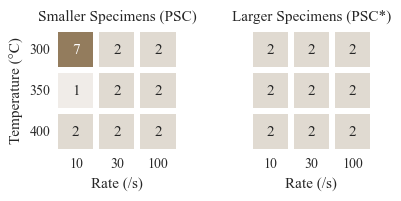

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(4.6,1.6))
heatmap_kwargs = dict(linewidths=4, cbar=False, annot=True, cmap=gold_cmap,  vmin=0, vmax=11)

pam.experimental_matrix(raw_ds.subset({'test type': 'PSC'}).info_table,
                             index='temperature', columns='rate', as_heatmap=True, title='Smaller Specimens (PSC)',
                             xlabel='Rate (/s)', ylabel='Temperature (°C)',
                             tick_params=dict(rotation=0), ax=axs[0], **heatmap_kwargs)

pam.experimental_matrix(raw_ds.subset({'test type': 'PSC*'}).info_table,
                             index='temperature', columns='rate', as_heatmap=True, title='Larger Specimens (PSC*)',
                             xlabel='Rate (/s)', ylabel=' ',
                             tick_params=dict(labelleft=False), ax=axs[1], **heatmap_kwargs);

### Setup plotting
Now that we know how to group the data, we can set up a plotting function.

In [6]:
styler = pam.plotting.Styler(color_by='temperature', color_by_label='(°C)', cmap='plasma', color_norm=plt.Normalize(300,500)
                             ).style_to(raw_ds)


def ds_subplot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(
        ds, shape=(2, 3), figsize=(8, 3.5),
        cols_by='rate', rows_by='test type',
        col_vals=[[10], [30], [100]], row_vals=[['PSC'], ['PSC*']],
        col_titles=['10 /s', '30 /s', '100/s'], row_titles=['Smaller Specimens', 'Larger Specimens'],
        styler=styler, plot_legend=False, subplot_legend=False,
        **kwargs
    )


stress_strain_labels = dict(x='Strain', y='Stress(MPa)', xlabel='Strain', ylabel='Stress (MPa)')

Plot the raw data.

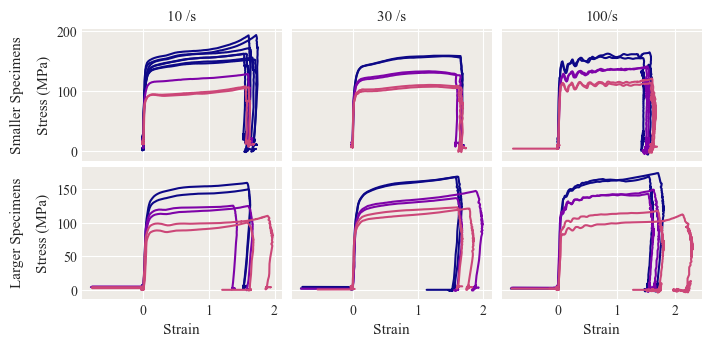

In [7]:
ds_subplot(raw_ds, **stress_strain_labels);

## Data processing

### Trim data

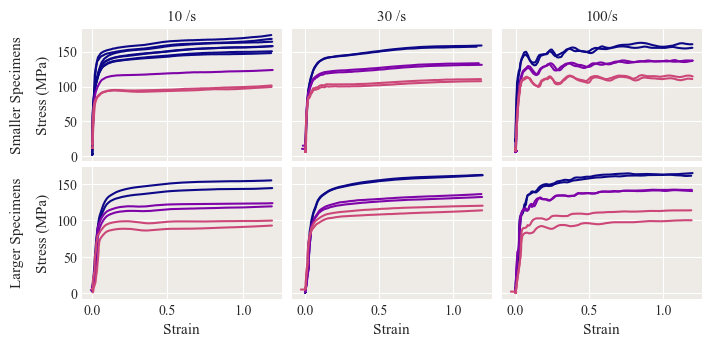

In [8]:
def drop_columns(di: DataItem) -> DataItem:
    for column in ['PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Stroke(mm)', 'wedge(mm)']:
        if column in di.data.columns:
            di.data = di.data.drop(columns=[column])
    return di


def trim_using_time_step(di: DataItem) -> DataItem:
    t_diff = np.diff(di.data['Time(sec)'])
    di.data['time diff'] = np.hstack([t_diff[0], t_diff])
    di.data = di.data[di.data['time diff'] < 0.02][1:]
    return di


def remove_trailing_data(di: DataItem):
    di.data = di.data[di.data['Strain'] < 1.2]
    return di

trimmed_ds = raw_ds.apply(drop_columns).apply(trim_using_time_step).apply(remove_trailing_data)
ds_subplot(trimmed_ds, **stress_strain_labels);

### Find flow stress values
Determine the stress, temperature for each test. Note that while nominal temperature is given, the actual test conditions are slightly different. The actual strain-rate does not differ significantly from the nominal rate for these tests.

In [9]:
rates_ds = pam.calculate_strain_rate(trimmed_ds, time_key='Time(sec)')

processed_ds = pam.find_flow_stress_values(rates_ds, flow_strain=(0.8, 0.9),
                              stress_key='Stress(MPa)', temperature_key='TC1(C)', rate_key='Strain_Rate'
                              ).sort_by('rate')

In [10]:
processed_ds.write_output('info/02 processed info.xlsx', 'data/02 processed data')

### Make representative curves

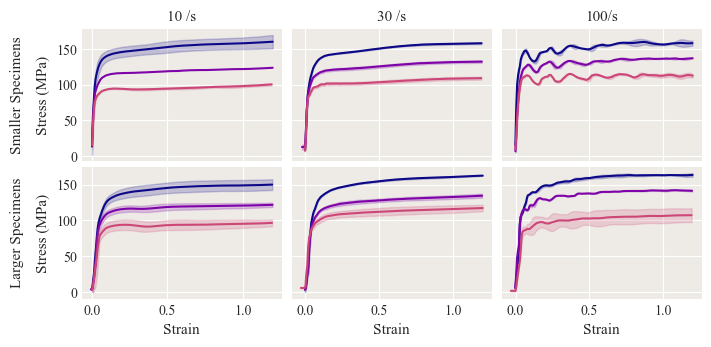

In [11]:
pam.make_representative_data(processed_ds, 'info/03 repr trim info.xlsx', 'data/03 repr trim data',
                             repres_col='Stress(MPa)', group_by_keys=['temperature', 'test type', 'rate'],
                             interp_by='Strain', group_info_cols=['flow_Stress(MPa)'])

repr_ds = DataSet('info/03 repr trim info.xlsx', 'data/03 repr trim data', test_id_key='repres_id').sort_by('temperature')

ds_subplot(repr_ds, x='Strain', y='Stress(MPa)', xlabel='Strain', ylabel='Stress (MPa)',
               fill_between=('down_std_Stress(MPa)', 'up_std_Stress(MPa)'));

### Zener-Holloman Analysis

In [12]:
default_cmap = plt.cm.get_cmap('RdYlGn')
colors = default_cmap(np.arange(default_cmap.N))
colors[0] = (1, 1, 1, 1)
custom_cmap = mpl.colors.ListedColormap(colors)

def conformance_matrix(_ds: DataSet):
    fig, axs = plt.subplots(1, 2, figsize=(4.6, 1.6))
    heatmap_kwargs = dict(linewidths=4, cbar=False, annot=True, fmt='.1f', cmap=custom_cmap, vmin=85, vmax=100)
    pam.make_quality_matrix(_ds.subset({'test type': 'PSC'}).info_table, index='temperature', columns='rate',
                            flow_stress_key='flow_Stress(MPa)', as_heatmap=True, title='Smaller Specimens (PSC)',
                            xlabel='Rate (/s)', ylabel='Temperature (°C)', tick_params=dict(rotation=0), ax=axs[0],
                            **heatmap_kwargs)
    pam.make_quality_matrix(_ds.subset({'test type': 'PSC*'}).info_table, index='temperature', columns='rate',
                            flow_stress_key='flow_Stress(MPa)', as_heatmap=True, title='Larger Specimens (PSC*)',
                            xlabel='Rate (/s)', ylabel=' ', tick_params=dict(labelleft=False), ax=axs[1],
                            **heatmap_kwargs)

In [13]:
info_table = processed_ds.info_table
info_table['Q_activation'] = 155000.
info_table['flow_temp(K)'] = info_table['flow_TC1(C)'] + 273.15
processed_ds.info_table = info_table
analysis_ds = processed_ds.apply(pam.calculate_ZH_parameter, rate_key='flow_Strain_Rate', temperature_key='flow_temp(K)')

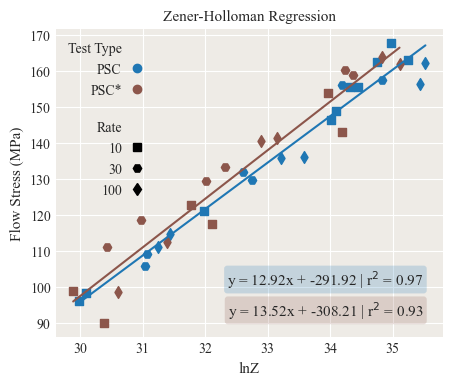

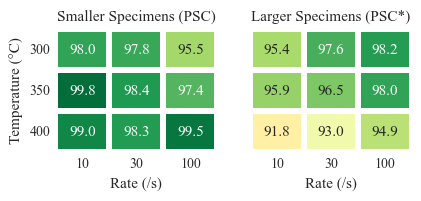

In [14]:
type_analysis_ds = pam.apply_ZH_regression(analysis_ds.copy(), flow_stress_key='flow_Stress(MPa)', group_by='test type')
ax = pam.plot_ZH_regression(type_analysis_ds, group_by='test type', color_by='test type', marker_by='rate', cmap='tab20',
                       flow_stress_key='flow_Stress(MPa)', rate_key='flow_Strain_Rate', temperature_key='flow_temp(K)',figsize=(5,4), eq_hscale=0.1)
conformance_matrix(type_analysis_ds)

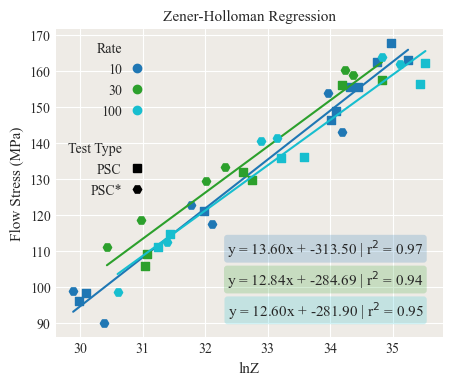

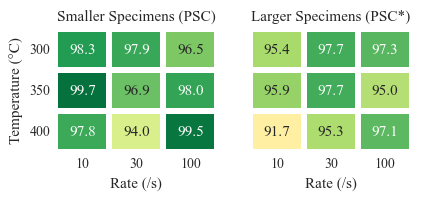

In [15]:
rate_analysis_ds = pam.apply_ZH_regression(analysis_ds.copy(), flow_stress_key='flow_Stress(MPa)', group_by='rate')
ax = pam.plot_ZH_regression(rate_analysis_ds, group_by='rate',
                       color_by='rate', marker_by='test type', cmap='tab10',
                       flow_stress_key='flow_Stress(MPa)', rate_key='flow_Strain_Rate', temperature_key='flow_temp(K)',figsize=(5,4),eq_hscale=0.1)
conformance_matrix(rate_analysis_ds)

### Tables

In [ ]:
df = pam.make_representative_info(type_analysis_ds, group_by_keys=['test type', 'rate', 'temperature'],
                                  group_info_cols=['lnZ_fit_residual', 'lnZ', 'ZH_parameter', 'flow_TC1(C)',
                                                   'flow_Stress(MPa)'])
table = df[['test type', 'rate', 'temperature', 'flow_Stress(MPa)', 'flow_TC1(C)', 'ZH_parameter', 'lnZ']].sort_values(['temperature', 'test type'])
table = table.reset_index().drop(columns=['index'])
table = table[['temperature', 'test type', 'rate', 'flow_Stress(MPa)', 'flow_TC1(C)',  'lnZ']]
table_s10 = table[table['rate'] == 10].drop(columns=['rate'])
table_s30 = table[table['rate'] == 30].drop(columns=['rate'])
table_s100 = table[table['rate'] == 100].drop(columns=['rate'])

In [ ]:
for col in ['flow_Stress(MPa)', 'flow_TC1(C)', 'lnZ']:
    table_s10[col] = table_s10[col].apply(lambda x: f'{x:.3g}')

table_s10.style.to_latex('info/s10_table.tex')

In [ ]:
for col in ['flow_Stress(MPa)', 'flow_TC1(C)',  'lnZ']:
    table_s30[col] = table_s30[col].apply(lambda x: f'{x:.3g}')

table_s30.style.to_latex('info/s30_table.tex')

In [ ]:
for col in ['flow_Stress(MPa)', 'flow_TC1(C)', 'lnZ']:
    table_s100[col] = table_s100[col].apply(lambda x: f'{x:.3g}')

table_s100.to_latex('info/s100_table.tex')